## Part 3: Creating a Machine Learning Model
The following code seeks to utilize pyspark to both navigate the data with SQL as well as build several machine learning models which will be tuned accordingly. For this part, I will be using the randomly generated evaluation data.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, expr
from pyspark.ml.feature import VectorAssembler, OneHotEncoder, StringIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier, DecisionTreeClassifier
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, DoubleType
from pyspark.mllib.evaluation import MulticlassMetrics

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, mean_absolute_error, r2_score, precision_recall_fscore_support
from sklearn.linear_model import LinearRegression, LogisticRegression, RANSACRegressor
from sklearn.ensemble import RandomForestRegressor


spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext
sc.setLogLevel("ERROR")

schema = StructType([
    StructField("age", IntegerType(), True),
    StructField("sex", StringType(), True),
    StructField("fusion", StringType(), True),
    StructField("provider", StringType(), True),
    StructField("brace", StringType(), True),
    StructField("pain", StringType(), True),
    StructField("prior_loc", IntegerType(), True),
    StructField("ste", IntegerType(), True),
    StructField("hr", IntegerType(), True),
    StructField("ad", IntegerType(), True),
    StructField("num_falls", IntegerType(), True),
    StructField("sup_sit", IntegerType(), True),
    StructField("sit_stand", IntegerType(), True),
    StructField("amb_assist", IntegerType(), True),
    StructField("amb_distance", IntegerType(), True),
    StructField("stairs_assist", IntegerType(), True),
    StructField("num_stairs", IntegerType(), True),
    StructField("los", DoubleType(), True),
    StructField("dc_loc", IntegerType(), True),
    StructField("need_rehab", IntegerType(), True)
])

spark_df = (
    spark.read
    .option('delimiter', ',')
    .option('header', True)
    .schema(schema)
    .csv('PTDataForML.csv')
)

spark_df.show()


+---+------+--------+--------+-----+--------+---------+---+---+---+---------+-------+---------+----------+------------+-------------+----------+----+------+----------+
|age|   sex|  fusion|provider|brace|    pain|prior_loc|ste| hr| ad|num_falls|sup_sit|sit_stand|amb_assist|amb_distance|stairs_assist|num_stairs| los|dc_loc|need_rehab|
+---+------+--------+--------+-----+--------+---------+---+---+---+---------+-------+---------+----------+------------+-------------+----------+----+------+----------+
| 97|  male|cervical|   Nolan| none|  severe|        3|  0|  0|  2|        3|      1|        1|         0|          96|            4|         0| 4.8|     6|         1|
| 67|  male|cervical|   Smith|aspen|moderate|        0|  0|  0|  2|        0|      2|        2|         2|          89|            4|         0| 4.1|     0|         0|
| 51|female|cervical|     Woo| none|moderate|        1|  1|  1|  1|        0|      1|        2|         0|         153|            4|         0| 2.2|     1|    

## Pipeline

We'll create a preprocessing pipeline and fit and tranform our Spark Dataframe. As we are using a Random Forest, we will not need to encode all features to integers at this time.

In [3]:
cat_features = ['sex', 'fusion', 'brace', 'provider', 'ad', 'prior_loc', 'pain', 'sup_sit', 'sit_stand', 'amb_assist', 'stairs_assist']
num_features = [col for col in spark_df.columns[:-3] if col not in cat_features]

ix_features = [c + '_ix' for c in cat_features]
label_indexer = StringIndexer(inputCol='need_rehab', outputCol='label')
feature_indexer = StringIndexer(inputCols=cat_features, outputCols=ix_features)
assembler = VectorAssembler(inputCols=num_features + ix_features, outputCol='features')

# Pipeline creation
pipeline = Pipeline(stages=[label_indexer, feature_indexer, assembler]).fit(spark_df)

spark_df_pipelined = pipeline.transform(spark_df)

train, test = spark_df_pipelined.randomSplit([0.8, 0.2], seed=1)

# We will use accuracy to score this model based on the predictions of the model and the true label.
accuracy_eval = MulticlassClassificationEvaluator(
    predictionCol='prediction', labelCol='label', metricName='accuracy')

We will confirm our sparse indexes.

In [5]:
train.select(['features']).show(10, truncate = False)

+--------------------------------------------------------------------------+
|features                                                                  |
+--------------------------------------------------------------------------+
|(17,[0,1,2,4,9,10,13,14],[36.0,3.0,1.0,14.0,4.0,1.0,2.0,1.0])             |
|[38.0,0.0,1.0,4.0,2.0,0.0,1.0,1.0,0.0,3.0,2.0,6.0,2.0,3.0,0.0,1.0,0.0]    |
|(17,[0,1,2,4,6,9,10,12,14,15],[38.0,2.0,1.0,61.0,1.0,3.0,1.0,2.0,2.0,1.0])|
|(17,[0,4,9,11,13,14,15],[41.0,103.0,2.0,1.0,1.0,1.0,4.0])                 |
|[45.0,1.0,2.0,0.0,184.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0]  |
|[45.0,3.0,2.0,0.0,132.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,3.0]  |
|(17,[0,2,3,4,8,9,10,11,13,15],[45.0,1.0,1.0,36.0,3.0,4.0,1.0,2.0,1.0,1.0])|
|[45.0,2.0,1.0,0.0,100.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,4.0,1.0,1.0,0.0]  |
|(17,[0,2,3,4,6,8,11,13,14],[45.0,1.0,1.0,77.0,1.0,2.0,2.0,1.0,2.0])       |
|[45.0,1.0,2.0,0.0,30.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,2.0,2.0,1.0,0.0]   |

### Random Forest Classifier

In [5]:
rforest = RandomForestClassifier(featuresCol='features', labelCol='label', numTrees=20, seed=1)

# Param grid for tuning of our model.
param_grid = (ParamGridBuilder()
              .addGrid(rforest.maxDepth, range(2, 18, 2) )
              .addGrid(rforest.minInstancesPerNode, [4, 8, 16, 32])
              ).build()

# Cross validation with 10 folds to reduce overfitting
cv = CrossValidator(estimator=rforest, estimatorParamMaps=param_grid, numFolds=10, 
                    evaluator=accuracy_eval, seed=1, parallelism=6)
 
cv_model = cv.fit(train)
 
opt_rf_model = cv_model.bestModel
opt_maxDepth = opt_rf_model.getMaxDepth()
opt_minInstancesPerNode = opt_rf_model.getMinInstancesPerNode()
 
print('Max CV Score:  ', round(max(cv_model.avgMetrics),4))
print('Optimal Max Depth:  ', opt_maxDepth)
print('Optimal MinInst:', opt_minInstancesPerNode)

24/08/08 15:18:58 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


Max CV Score:   0.8668
Optimal Depth:   6
Optimal MinInst: 8


We will graph our parameters to ensure there is not a set of parameters we might be missing which could produce a stronger cross-validation score.

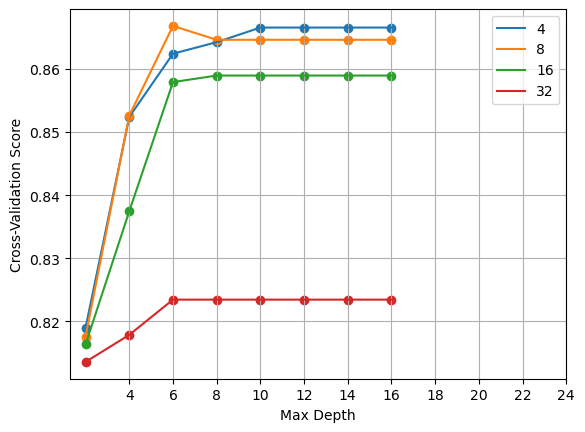

In [6]:
def graph_params(model): 
    model_params = model.getEstimatorParamMaps()
    dt_cv_summary_list = []
    for param_set, acc in zip(model_params, model.avgMetrics):
        new_set = list(param_set.values()) + [acc]
        dt_cv_summary_list.append(new_set)
    cv_summary = pd.DataFrame(dt_cv_summary_list,
                                columns=['maxDepth', 'minInst', 'acc'])
    for mi in cv_summary.minInst.unique():
        sel = cv_summary.minInst == mi
        plt.plot(cv_summary.maxDepth[sel], cv_summary.acc[sel], label=mi)
        plt.scatter(cv_summary.maxDepth[sel], cv_summary.acc[sel])
    plt.legend()
    plt.grid()
    plt.xticks(range(4,26,2))
    plt.xlabel('Max Depth')
    plt.ylabel('Cross-Validation Score')
    plt.show()


graph_params(cv_model)

We will calculate the proportions of need_rehab for our data to confirm our model has learned something and performs better than if we had predicted all outcomes to be the same.

In [7]:
def count_proportions(test_predictions):
    N = test_predictions.count()
    df = test_predictions.select('need_rehab').groupBy('need_rehab').agg(
        expr('count(*) as count'), 
        expr(f'round(count(*)/{N},2) as prop')
    ).show()
    
    return df
def model_accuracy(model, test_set):
    test_pred = model.transform(test_set)
    pred_and_labels = test_pred.rdd.map(lambda x:(x['prediction'],float(x['label'])))
    metrics = MulticlassMetrics(pred_and_labels)
    
    return metrics.accuracy

def model_cm(model, test_set):
    test_pred = model.transform(test_set)
    pred_and_labels = test_pred.rdd.map(lambda x:(x['prediction'],float(x['label'])))
    metrics = MulticlassMetrics(pred_and_labels)
    cm = metrics.confusionMatrix().toArray().astype(int)
    labels = range(0,2)
    matrix = pd.DataFrame(
        data=cm, 
        columns=labels,
        index=labels
    )
    return matrix


print(count_proportions(opt_rf_model.transform(test)))
print(f'Model Accuracy: {model_accuracy(opt_rf_model, test)}')
print(model_cm(opt_rf_model, test))

+----------+-----+----+
|need_rehab|count|prop|
+----------+-----+----+
|         1|  102|0.57|
|         0|   77|0.43|
+----------+-----+----+

None


/Users/trevoratnip/anaconda3/lib/python3.11/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Model Accuracy: 0.8659217877094972
    0   1
0  96   6
1  18  59


Now we will determine which variables appear most important in determining need_rehab.

In [8]:
def importances(numerical_ft, categorical_ft, model):
    ft = numerical_ft+categorical_ft
    importance = pd.DataFrame({
        'features' : ft
    })
    importance['importance'] = 0.0
    lst = list(model.featureImportances)
    
    for index, value in enumerate(lst):
        importance.loc[index,'importance'] = value
    return importance

importances(num_features, cat_features, opt_rf_model).sort_values('importance', ascending = False)

,features,importance
4,amb_distance,0.553421
11,prior_loc,0.187503
7,fusion,0.056931
16,stairs_assist,0.038575
12,pain,0.021116
15,amb_assist,0.020842
9,provider,0.020457
3,num_falls,0.018737
8,brace,0.015906
14,sit_stand,0.013513


It is important to remember that much of the data is completely random and almost nonsensical currently. We can predict that this will reduce importances of items we did not include in our assumptions when producing the random data. We can, however, see that ambulation distance as well as prior level of function have significant importances greater than the other features.

Let's reduce the number of features to see if we can create a stronger model.

In [9]:
spark_df_reduced = spark_df.select('num_falls', 'amb_distance', 'fusion', 'prior_loc', 'pain', 'need_rehab')

cat_features_reduced = ['fusion', 'prior_loc', 'pain']
num_features_reduced = ['num_falls', 'amb_distance']

ix_features_reduced = [c + '_ix' for c in cat_features_reduced]
label_indexer = StringIndexer(inputCol='need_rehab', outputCol='label')
feature_indexer = StringIndexer(inputCols=cat_features_reduced, outputCols=ix_features_reduced)
assembler = VectorAssembler(inputCols=num_features_reduced + ix_features_reduced, outputCol='features')


pipeline = Pipeline(stages=[label_indexer, feature_indexer, assembler]).fit(spark_df_reduced)

spark_df_pipeline_reduced = pipeline.transform(spark_df_reduced)

train_reduced, test_reduced = spark_df_pipeline_reduced.randomSplit([0.8, 0.2], seed=1)

accuracy_eval = MulticlassClassificationEvaluator(
    predictionCol='prediction', labelCol='label', metricName='accuracy')

In [11]:
rforest = RandomForestClassifier(featuresCol='features', labelCol='label', numTrees=20, seed=1)
 
param_grid = (ParamGridBuilder()
              .addGrid(rforest.maxDepth, range(2, 18, 2) )
              .addGrid(rforest.minInstancesPerNode, [4, 8, 16, 32])
              ).build()
 
cv_reduced = CrossValidator(estimator=rforest, estimatorParamMaps=param_grid, numFolds=10, 
                    evaluator=accuracy_eval, seed=1, parallelism=6)
 
cv_model_reduced = cv_reduced.fit(train_reduced)
 
opt_rf_model_reduced = cv_model_reduced.bestModel
opt_maxDepth_reduced = opt_rf_model_reduced.getMaxDepth()
opt_minInstancesPerNode_reduced = opt_rf_model_reduced.getMinInstancesPerNode()
 
print('Max CV Score:  ', round(max(cv_model_reduced.avgMetrics),4))
print('Optimal Maximum Depth:  ', opt_maxDepth_reduced)
print('Optimal MinInst:', opt_minInstancesPerNode_reduced)

Max CV Score:   0.8599
Optimal Depth:   8
Optimal MinInst: 4


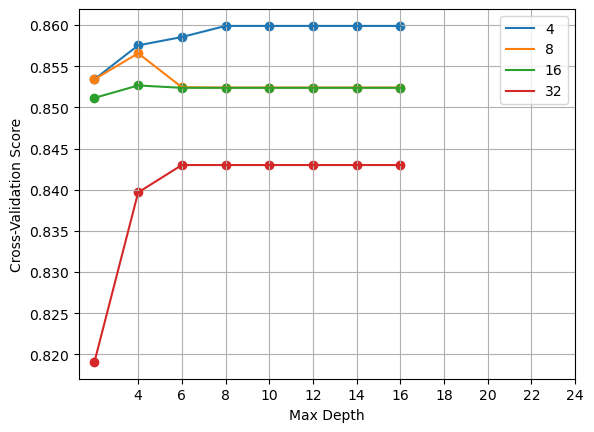

+----------+-----+----+
|need_rehab|count|prop|
+----------+-----+----+
|         1|   98|0.55|
|         0|   81|0.45|
+----------+-----+----+

None


/Users/trevoratnip/anaconda3/lib/python3.11/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Model Accuracy: 0.8770949720670391
    0   1
0  93   5
1  17  64


,features,importance
1,amb_distance,0.607454
3,prior_loc,0.258125
0,num_falls,0.046749
4,pain,0.046718
2,fusion,0.040954


In [12]:
# We will perform the same metrics and tests as we had on the prior rf model.
graph_params(cv_model_reduced)
print(count_proportions(opt_rf_model_reduced.transform(test_reduced)))
print(f'Model Accuracy: {model_accuracy(opt_rf_model_reduced, test_reduced)}')
print(model_cm(opt_rf_model_reduced, test_reduced))
importances(num_features_reduced, cat_features_reduced, opt_rf_model_reduced).sort_values('importance', ascending= False)

When attempting to reduce the noise, we receive approximately the same results with some small shifts in precision and recall. 

### Logistic Regression
We will now compare Logistic Regression to our Random Forest model.

I will also switch over to the sci-kit learn library to perform this analysis. 

In order to accomplish logistic regression, we will need to encode our:
* nominal features(sex, fusion, provider, prior_loc, ad), 
* ordinal features (brace, pain, sup_sit, sit_stand, amb_assist, stairs_assist) \


and standardize the rest of the numerical features (age, ste, hr, num_falls, amb_distance, num_stairs).

In [17]:
df = spark_df.toPandas()
## Ordinal feature encoding of pain into two groups: mild+moderate and severe
df['pain_severe'] = df['pain'].apply(lambda x: 1 if x == 'severe' else 0)
df['pain_min_mod'] = df['pain_severe'].apply(lambda x: 0 if x == 1 else 1)
del df['pain']

## Ordinal brace encoding
df['brace_none'] = df['brace'].apply(lambda x: 1 if x =='none' else 0)
df['brace_lso'] = df['brace'].apply(lambda x: 1 if x =='lso' else 0)
df['brace_tlso'] = df['brace'].apply(lambda x: 1 if x =='tlso' else 0)
df['brace_aspen'] = df['brace'].apply(lambda x: 1 if x == 'aspen' else 0)
del df['brace']

### Mobility

As it stands, there is a significant amount of colinear data contained in sup_sit, sit_stand, amb_assist, and stairs_assist. An individual will not have ambulated if they did not stand. They will not stand if they have not performed supine to sit. It may be best to converge supine to sit and sit to stand into a single binary column which demonstrates whether the patient was able to stand at all. Amb_assist and stairs_assist may also be excluded as we might surmise that if the patient performed a long ambulation or performed several steps, they did not require as much assistance. 

In [18]:
df['stand'] = df['sit_stand'].apply(lambda x: 1 if x in (0,1,2,3) else 0)
del df['sup_sit']
del df['sit_stand']
del df['stairs_assist']
del df['amb_assist']

In [19]:
## Nominal encoding of sex, fusion, provider, prior_loc, ad
prior_loc_dict = {
    '1sh': 0,
    '2sh': 1,
    'apt': 2,
    'ilf': 3,
    'alf': 4,
    'snf': 5,
    'ipr': 6,
    'ltc': 7
}

ad_dict = {
    'none': 0,
    'cane': 1,
    'walker': 2
}

inverse_prior_loc_mapping = {v: k for k,v in prior_loc_dict.items()}
inverse_ad_mapping = {v: k for k,v in ad_dict.items()}

df['prior_loc'] = df['prior_loc'].map(inverse_prior_loc_mapping)
df['ad'] = df['ad'].map(inverse_ad_mapping)


col_encoded = pd.get_dummies(df[['sex', 'fusion', 'provider', 'prior_loc', 'ad']], dtype = 'int64')

In [20]:
df = pd.concat([df, col_encoded], ignore_index = False, axis = 1)

del df['sex']
del df['fusion']
del df['provider']
del df['prior_loc']
del df['ad']

## Reorganized columns so that labels are at the end for convenience
df = (
    df[
    [col for col in df.columns if col not in ['los', 'dc_loc', 'need_rehab']]
    + ['los'] + ['dc_loc'] + ['need_rehab']]
)

### Standardization

I will split the data into training and testing samples which are stratified on the need_rehab label. Considering the dataset is relatively small and may contain significant outliers, we will use the RobustScaler class from Scikit-Learn to standardize our data.

In [21]:
## Split and standardize data
X, y = df.iloc[:,0:-3], df.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify = y)
standardizer = RobustScaler()

X_train_std = standardizer.fit_transform(X_train)
X_test_std = standardizer.fit_transform(X_test)

In [22]:
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'penalty': ['l2']
}

# Logistic Regression model for classification
log_reg = LogisticRegression(solver='newton-cholesky', multi_class = 'ovr' )
gridsearch_lr = GridSearchCV(estimator = log_reg, param_grid=param_grid, cv=5, scoring='accuracy')

gridsearch_lr.fit(X_train_std, y_train)

best_params = gridsearch_lr.best_params_
print("Best Parameters:", best_params)

best_model = gridsearch_lr.best_estimator_
y_pred = best_model.predict(X_test_std)


accuracy = accuracy_score(y_test, y_pred)
print('Training Accuracy:', gridsearch_lr.score(X_train_std, y_train))
print("Test Set Accuracy:", accuracy)

Best Parameters: {'C': 100, 'penalty': 'l2'}
Training Accuracy: 0.85875
Test Set Accuracy: 0.815


In [23]:
cm_lr = confusion_matrix(y_true = y_test, y_pred = y_pred)

print(cm_lr)

[[66 22]
 [15 97]]


### Best model

Based on the results, our random forest model returned a stronger accuracy over the entire test set compared to the logistic regression model. 

## Regression Models to predict Length-of-Stay

We will now attempt to predict Length-of-Stay using two models: **Linear Regression** and **Random Forest Regression**

There are likely significant outliers in our dataset. We will utilize the RANSAC algorithm to fit a regression model on the inliers. 

In [28]:
# Split data
X, y = df.iloc[:,0:-3], df.loc[:,'los']

X = standardizer.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# Determine study-based residual threshold to include in param_grid
median_y = np.median(y_train)
mad_y = np.median(np.abs(y_train - median_y))
residual_threshold = 1.4826 * mad_y 

param_grid = {
    'max_trials': [50, 100, 200],
    'min_samples': [0.5, 0.75, 0.95],
    'residual_threshold': [1.0, 1.4826, 2.0, residual_threshold]
}
ransac = RANSACRegressor()

# Set up GridSearchCV for tuning
grid_search = GridSearchCV(estimator=ransac, param_grid=param_grid, cv=5, scoring='r2')

grid_search.fit(X_train, y_train)


best_ransac = grid_search.best_estimator_

# Make predictions with the best model
y_pred = best_ransac.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Best Parameters: {grid_search.best_params_}')
print(f'Mean Absolute Error: {mae}')
print(f'R^2 Score: {r2}')

Best Parameters: {'max_trials': 50, 'min_samples': 0.95, 'residual_threshold': 3.5582400000000005}
Mean Absolute Error: 1.817263671875
R^2 Score: 0.4402231234121694


The RANSAC R^2 score is low. We will also perform Random Forest Regression to compare.

In [29]:
# Split the data
X, y = df.iloc[:,0:-3], df.loc[:,'los']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# Random Forest Regression model
rfr = RandomForestRegressor(
    n_estimators = 1000,
    random_state = 1,
    n_jobs = -1)
rfr.fit(X_train, y_train)

#Create predictions
y_train_pred = rfr.predict(X_train)
y_test_pred = rfr.predict(X_test)

# Determine performance
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

print(f' MAE train: {mae_train:.2f}')
print(f' MAE test: {mae_test:.2f}')

r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
print(f'R^2 train: {r2_train:.2f}')
print(f'R^2 test: {r2_test:.2f}')

 MAE train: 0.48
 MAE test: 1.26
R^2 train: 0.96
R^2 test: 0.69


We can see from our R^2 results that there is a significant amount of overfitting occurring due to the 0.27 difference between training and testing R^2. We will attempt to tune hyperparameters to improve our performance on the test set.

In [30]:
param_grid = {
    'n_estimators': [100, 250, 500, 750],
    'max_depth': [None, 3, 4, 5, 8, 10],
    'min_samples_split': [10, 15, 20, 30],
    'min_samples_leaf': [2, 4, 6, 8],
    'max_features' : ['sqrt', 'log2', None]
}

grid_search_rfr = GridSearchCV(estimator=RandomForestRegressor(random_state=1), 
                           param_grid=param_grid, 
                           cv=5, 
                           scoring='r2',
                           n_jobs=-1)

grid_search_rfr.fit(X_train, y_train)

# Get the best estimator
best_rfr = grid_search_rfr.best_estimator_

# Create predictions with the best model
y_train_pred = best_rfr.predict(X_train)
y_test_pred = best_rfr.predict(X_test)

# Evaluate the model
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

best_params = grid_search_rfr.best_params_
print("Best Parameters:", best_params)
print(f' MAE train: {mae_train:.2f}')
print(f' MAE test: {mae_test:.2f}')

r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
print(f'R^2 train: {r2_train:.2f}')
print(f'R^2 test: {r2_test:.2f}')

Best Parameters: {'max_depth': 3, 'max_features': None, 'min_samples_leaf': 8, 'min_samples_split': 30, 'n_estimators': 250}
 MAE train: 1.20
 MAE test: 1.24
R^2 train: 0.73
R^2 test: 0.70


## Models for prediction

Based on the results of this study, our best model to predict length-of-stay is our Random Forest Regressor model with the parameters of {'max_depth': 3, 'max_features': None, 'min_samples_leaf': 8, 'min_samples_split': 30, 'n_estimators': 250}. For this model, we received an R^2 of 0.70. This tells us that our current data accounts for about **70%** of the variation in length-of-stay. 

Our best model **based on accuracy** to predict need for rehabilitation is the Random Forest Classifier model with the parameters of {'max_depth': 6, 'minInstancesperNode': 8}. Based on the accuracy score of 0.86, we are able to predict the outcome of need for rehabilitation based on the evaluation alone with this data roughly **86%** of the time. Precision was 92.75% for this model, while recall was 79.01%. Precision for the logistic regression model was 81.51% and recall was 86.61%. Based on precision and recall, it may be **more beneficial to utilize the logistic regression model** for need_rehab. This is because it likely is more beneficial to identify patients who are more likely to need rehab as there are a number of hospital processes that benefit from beginning earlier such as referrals for authorization and reduced plan of care to reduce length-of-stay for that patient in the acute care setting and improve frequency of those patients that are not expected to discharge to rehab to reduce length-of-stay for those patients as well.